# Implementation of the paper Label refinement network from synthetic error augmentation for medical image segmentation

## Imports

In [14]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import numpy as np
import random
from torch.utils.data import Dataset , random_split
from PIL import Image
import os
from skimage.morphology import skeletonize
from skimage.exposure import equalize_adapthist # CLAHE

# 1. Définir le seed pour les générateurs d'aléas de base
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# 2. Définir le seed pour PyTorch (CPU et, si disponible, GPU)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


### Create Dataset

In [15]:
class DRIVEDataset(Dataset):
    """ Class to load the Drive dataset"""
    def __init__(self, root_dir : str, split, transform=None):
        """
        :param root_dir: Path to the repository of the dataset
        :type root_dir: str
        :param split: "training" or "test" to load
        :type split: str
        :param transform: Transform to apply to the image
        :type transform: 
        """
        # Set the initials parameters
        self.root_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.root_dir, 'images')
        self.gt_dir = os.path.join(self.root_dir, '1st_manual')
        self.mask_dir = os.path.join(self.root_dir, 'mask')
        self.transform = transform

        # Liste des noms de fichiers (ex: ['21_training', '22_training', ...])
        self.ids = [f.split('_')[0] for f in os.listdir(self.image_dir) if f.endswith('.tif')]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        img_id = self.ids[index]

        # 1. Charger l'Image, le Ground Truth et le Masque FOV
        img_name = f"{img_id}_training.tif" if 'training' in self.root_dir else f"{img_id}_test.tif"
        gt_name = f"{img_id}_manual1.gif"
        mask_name = f"{img_id}_training_mask.gif" if 'training' in self.root_dir else f"{img_id}_test_mask.gif"

        # Open the images
        image = Image.open(os.path.join(self.image_dir, img_name))
        ground_truth = Image.open(os.path.join(self.gt_dir, gt_name))
        mask_fov = Image.open(os.path.join(self.mask_dir, mask_name))

        # Conversion en NumPy pour le pré-traitement
        image_np = np.array(image)
        gt_np = np.array(ground_truth) / 255.0  # Normalisation à 0 ou 1
        mask_np = np.array(mask_fov) / 255.0  # Normalisation à 0 ou 1

        # 2. Extraction du Canal Vert et CLAHE (Amélioration du Contraste)
        # DRIVE utilise le canal Vert (index 1) pour le meilleur contraste
        green_channel = image_np[:, :, 1]
        
        # Appliquer CLAHE et Normalisation (échelle 0-1)
        # CLAHE = méthode d'Égalisation d'Histogramme Adaptative avec Limitation de Contraste. Afin d'améliorer le contraste local rendant les structures fines visibles. 
        enhanced_image = equalize_adapthist(green_channel, clip_limit=0.01)

        # Normalisation finale de l'image améliorée (échelle 0-1)
        enhanced_image = (enhanced_image - np.min(enhanced_image)) / (np.max(enhanced_image) - np.min(enhanced_image))

        # 3. Application du Masque FOV et Redimensionnement
        enhanced_image = enhanced_image * mask_np 
        gt_np = gt_np * mask_np

        # 5. Conversion en Tenseurs PyTorch (float32)
        # PyTorch attend le format (C, H, W). Les images sont 1-canal (C=1).
        image_tensor = torch.from_numpy(enhanced_image).float().unsqueeze(0)
        gt_tensor = torch.from_numpy(gt_np).float().unsqueeze(0)

        return {'image': image_tensor, 'ground_truth': gt_tensor}

In [16]:
from torch.utils.data import DataLoader

# Définissez le chemin de votre dataset
DRIVE_PATH ="DRIVE"
BATCH_SIZE = 8

# 1. Instanciation du Dataset
train_dataset = DRIVEDataset(root_dir=DRIVE_PATH, split='training')
test_dataset = DRIVEDataset(root_dir=DRIVE_PATH, split='test') # Pour la validation/test

# Nombre total d'échantillons
total_size = len(train_dataset)

# Calculer les tailles pour le split (ex: 70% train, 30% val)
val_size_ratio = 0.2
val_size = int(val_size_ratio * total_size)
train_size = total_size - val_size

# Affichage des tailles (facultatif)
print(f"Total samples: {total_size}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")

# Train and val subsets
train_subset, val_subset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed) # Assure la reproductibilité
)

# 3. Créer les DataLoaders
BATCH_SIZE = 8
NUM_WORKERS = 0

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,       # Mélanger uniquement les données d'entraînement
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,      # Pas besoin de mélanger les données de validation
    num_workers=NUM_WORKERS
)

print(f"Train Loader ready (batches: {len(train_loader)})")
print(f"Validation Loader ready (batches: {len(val_loader)})")

Total samples: 20
Train size: 16
Validation size: 4
Train Loader ready (batches: 2)
Validation Loader ready (batches: 1)


In [17]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def display_processed_sample(sample_dict, index=None):
    """
    Affiche l'image traitée (canal vert amélioré) et le ground truth.
    
    Args:
        sample_dict (dict): Le dictionnaire retourné par __getitem__.
        index (int, optional): L'index de l'échantillon pour le titre.
    """
    # Récupérer les Tenseurs
    image_tensor = sample_dict['image']
    gt_tensor = sample_dict['ground_truth']
    
    # 1. Conversion des Tensors (C, H, W) en NumPy (H, W) pour Matplotlib
    # On supprime la dimension du canal (C=1)
    image_np = image_tensor.squeeze(0).cpu().numpy()
    gt_np = gt_tensor.squeeze(0).cpu().numpy()

    # Configuration de la figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    title_suffix = f" (Index: {index})" if index is not None else ""
    
    # Pour une image mono-canal (H, W) normalisée (0-1), cmap='gray' est idéal.
    axes[0].imshow(image_np, cmap='gray')
    axes[0].set_title(f"Image Traitée (Canal Vert + CLAHE){title_suffix}")
    axes[0].axis('off')

    # --- Afficher le Ground Truth (Masque de Vaisseaux) ---
    axes[1].imshow(gt_np, cmap='gray')
    axes[1].set_title("Ground Truth (Vaisseaux)")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

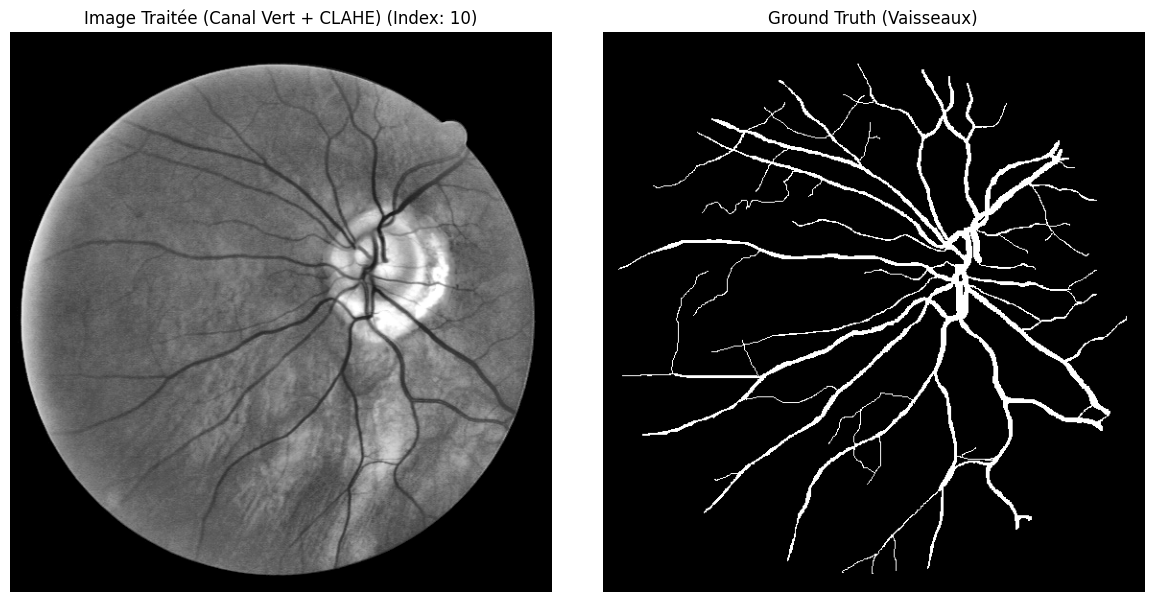

In [18]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np



# 1. Choisissez un index à vérifier (par exemple, le 5ème élément)
sample_index = 10

# 2. Récupérez l'échantillon du Dataset
try:
    # Récupération de l'échantillon qui est maintenant un DICTIONNAIRE
    sample_dict = train_dataset[sample_index]
    
    # 3. Appelez la fonction pour afficher, en passant le dictionnaire
    # Le 'index=sample_index' est correct pour le titre de la figure.
    display_processed_sample(sample_dict, index=sample_index)

except IndexError:
    print(f"Erreur : L'index {sample_index} est en dehors de la plage du dataset.")
except Exception as e:
    print(f"Une erreur s'est produite lors de l'affichage : {e}")

## U-net

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Flatten(nn.Module):
    """Module pour aplatir le tenseur (utilisé souvent pour les couches fully connected, moins pour le U-Net)"""
    def forward(self, x):
        # x.size()[0] est la taille du batch
        x = x.view(x.size()[0], -1) 
        return x


class DoubleConv(nn.Module):
    """(convolution => [InstanceNorm2d] => LeakyReLU) * 2 pour les blocs U-Net 2D"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace=False)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling avec MaxPool2d puis DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling puis DoubleConv, avec connexion de saut (skip connection)"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # Reconstruction bilinear
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Gestion du padding/cropping pour que x1 (upsampled) et x2 (skip) correspondent en H et W.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        # F.pad(input, (padding_left, padding_right, padding_top, padding_bottom))
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concaténation le long de la dimension des canaux (dim=1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Up_no_skip(nn.Module):
    """Upscaling puis DoubleConv, sans connexion de saut (skip connection)"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        # Le nombre de canaux en entrée ici est réduit (in_channels//2) car il n'y a pas de skip connection
        self.conv = DoubleConv(in_channels // 2, out_channels) 

    def forward(self, x1):
        x1 = self.up(x1)
        return self.conv(x1)


class Out_Seg(nn.Module):
    """Couche de sortie pour la segmentation (1x1 Conv + Sigmoid)"""
    def __init__(self, in_channels, out_channels):
        super(Out_Seg, self).__init__()
        # Crée une convolution 2D avec segmentation
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # Fais des probabilités dessus
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.conv(x))


class Out_Rec(nn.Module):
    """Couche de sortie pour la reconstruction (1x1 Conv, sans activation)"""
    def __init__(self, in_channels, out_channels):
        super(Out_Rec, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [20]:
""" Full assembly of the parts to form the complete network """

class UNet_2D(nn.Module):
    def __init__(self, job_description, bilinear=True, skip=True, LR=False):
        super(UNet_2D, self).__init__()
        self.LR = LR
        self.n_channels = 1
        if self.LR:
            self.n_channels = 2
        self.n_classes = 1
        self.n_rec_maps = 1
        self.base_features = job_description['base_features']
        self.dropout_rate = job_description['dropout_rate']
        self.bilinear = bilinear
        self.skip = skip

        self.inc = DoubleConv(self.n_channels, self.base_features)
        
        # Go down the U
        self.down1 = Down(self.base_features, self.base_features*2)
        self.down2 = Down(self.base_features*2, self.base_features*4)
        self.down3 = Down(self.base_features*4, self.base_features*4)
        self.down4 = Down(self.base_features*4, self.base_features*4)

        # Up with skip or not
        if self.skip:
            self.up1_skip = Up(self.base_features*(4+4), self.base_features*4, self.bilinear)
            self.up2_skip = Up(self.base_features*(4+4), self.base_features*2,self.bilinear)
            self.up3_skip = Up(self.base_features*(2+2), self.base_features, self.bilinear)
            self.up4_skip = Up(self.base_features*(1+1), self.base_features, self.bilinear)
        else:
            self.up1 = Up_no_skip(self.base_features*(4), self.base_features*4, self.bilinear)
            self.up2 = Up_no_skip(self.base_features*(4), self.base_features*2, self.bilinear)
            self.up3 = Up_no_skip(self.base_features*(2), self.base_features,  self.bilinear)
            self.up4 = Up_no_skip(self.base_features*(1), self.base_features,  self.bilinear)

        self.seg = Out_Seg(self.base_features, self.n_classes)
        self.rec = Out_Rec(self.base_features, self.n_rec_maps)

    def forward(self, x):
        x1 = self.inc(x)

        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        if self.skip:
            x_up_1 = self.up1_skip(x5, x4)
            x_up_2 = self.up2_skip(x_up_1, x3)
            x_up_3 = self.up3_skip(x_up_2, x2)
            x_up_4 = self.up4_skip(x_up_3, x1)
        elif not self.skip:
            x_up_1 = self.up1(x5)
            x_up_2 = self.up2(x_up_1)
            x_up_3 = self.up3(x_up_2)
            x_up_4 = self.up4(x_up_3)

        seg = self.seg(x_up_4)

        return seg

### Entrainement de la segmentation

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class SegmentationTrainer:
    """
    Classe pour gérer le processus d'entraînement d'un modèle UNet 2D.
    """
    def __init__(self, model, criterion, optimizer, device):
        self.device = device
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.history = {'train_loss': [], "val_loss" : []}

    def train_epoch(self, data_loader):
        """
        Effectue un seul epoch d'entraînement.
        """
        self.model.train() # Mode entraînement
        running_loss = 0.0
        
        for i, data in enumerate(data_loader):

            # Récupérer les données du dictionnaire
            images = data['image'].to(self.device)
            targets = data['ground_truth'].to(self.device)

            # Zéro des gradients
            self.optimizer.zero_grad()

            # Forward pass
            # Probabilités d'être un pixel
            outputs = self.model(images)
            
            # Calcul de la perte
            loss = self.criterion(outputs, targets)
            
            # Backward pass et optimisation
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0) # Accumule la perte totale pondérée

        epoch_loss = running_loss / len(data_loader.dataset)
        return epoch_loss
    
    def validate_epoch(self, data_loader):
        """
        Effectue une seule époque de validation.
        """
        self.model.eval() # Mode évaluation (désactive dropout, batch norm figé)
        running_loss = 0.0
        
        # Désactive le calcul de gradient pour l'évaluation
        with torch.no_grad():
            for data in data_loader:
                images = data['image'].to(self.device)
                targets = data['ground_truth'].to(self.device)
                
                # Le modèle renvoie déjà une probabilité
                outputs = self.model(images)

                print(f"Probabilities Mean: {outputs.mean().item():.2e}")
                
                loss = self.criterion(targets, outputs)
                running_loss += loss.item() * images.size(0)

        val_loss = running_loss / len(data_loader.dataset)
        return val_loss

    def train(self, train_loader, val_loader, num_epochs, save_path='./best_model.pth'):
        """
        Lance le processus d'entraînement complet avec validation.
        """
        print(f"Démarrage de l'entraînement sur {num_epochs} époques avec {self.device}")
        
        # Sauvegarder le modèle qui a la plus PETITE perte de validation
        best_val_loss = float('inf') 

        for epoch in range(num_epochs):
            # 1. Entraînement
            train_loss = self.train_epoch(train_loader)
            
            # 2. Validation
            val_loss = self.validate_epoch(val_loader)
            
            # Enregistrement
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            
            print(f"Époque [{epoch+1}/{num_epochs}] | Perte (Train): {train_loss:.4f} | Perte (Val): {val_loss:.4f}")

            # 3. Sauvegarde du meilleur modèle
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_model(save_path, val_loss)
                print("  => Nouveau meilleur modèle sauvegardé (basé sur la perte de validation).")
        
        print("Entraînement terminé.")

    def save_model(self, path, loss):
        """
        Sauvegarde l'état du modèle et de l'optimiseur.
        """
        torch.save({
            'epoch': len(self.history['train_loss']),
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
        }, path)

In [22]:
import torch
import torch.nn as nn
from torch.autograd import Function
import numpy as np


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-4):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, y_pred, y_true):
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

In [46]:
# --- Définitions (basées sur votre code précédent) ---
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
job_description = {'base_features': 32, 'dropout_rate': 0.1} # Exemple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Modèle
model = UNet_2D(job_description, skip=True, bilinear=True) 

# 2. Perte (Loss)
criterion = DiceLoss() 

# 3. Optimiseur
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) 


# Instanciation du Trainer
trainer = SegmentationTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

# Lancement de l'entraînement AVEC le val_loader
print(f"Démarrage de l'entraînement pour {NUM_EPOCHS} époques...")
trainer.train(
    train_loader=train_loader, # Vient de votre code
    val_loader=val_loader,     # Vient de votre code
    num_epochs=NUM_EPOCHS,
    save_path='./unet_drive_best_validated.pth'
)

Démarrage de l'entraînement pour 50 époques...
Démarrage de l'entraînement sur 50 époques avec cuda
Probabilities Mean: 3.73e-01
Époque [1/50] | Perte (Train): 0.8518 | Perte (Val): 0.8379
  => Nouveau meilleur modèle sauvegardé (basé sur la perte de validation).
Probabilities Mean: 3.73e-01
Époque [2/50] | Perte (Train): 0.8232 | Perte (Val): 0.8220
  => Nouveau meilleur modèle sauvegardé (basé sur la perte de validation).
Probabilities Mean: 3.73e-01
Époque [3/50] | Perte (Train): 0.8064 | Perte (Val): 0.8057
  => Nouveau meilleur modèle sauvegardé (basé sur la perte de validation).
Probabilities Mean: 3.71e-01
Époque [4/50] | Perte (Train): 0.7890 | Perte (Val): 0.7886
  => Nouveau meilleur modèle sauvegardé (basé sur la perte de validation).
Probabilities Mean: 3.68e-01
Époque [5/50] | Perte (Train): 0.7714 | Perte (Val): 0.7709
  => Nouveau meilleur modèle sauvegardé (basé sur la perte de validation).
Probabilities Mean: 3.65e-01
Époque [6/50] | Perte (Train): 0.7534 | Perte (Val)

In [47]:
import matplotlib.pyplot as plt

def plot_loss_history(history):
    """
    Affiche la perte d'entraînement (train loss) et la perte de validation (val loss) 
    en fonction des époques.
    
    Args:
        history (dict): Le dictionnaire retourné par SegmentationTrainer.history
                        contenant les clés 'train_loss' et 'val_loss'.
    """
    if not history:
        print("L'historique d'entraînement est vide.")
        return

    epochs = range(1, len(history['train_loss']) + 1)
    
    # Création de la figure
    plt.figure(figsize=(10, 6))
    
    # Courbe de perte d'entraînement
    plt.plot(epochs, history['train_loss'], 'b-o', label='Perte d\'Entraînement')
    
    # Courbe de perte de validation
    if 'val_loss' in history and history['val_loss']:
        plt.plot(epochs, history['val_loss'], 'r-o', label='Perte de Validation')
    
    # Titre et labels
    plt.title('Historique de la Perte (Loss)')
    plt.xlabel('Époques')
    plt.ylabel('Perte (Dice Loss)')
    plt.legend()
    plt.grid(True)
    plt.show()

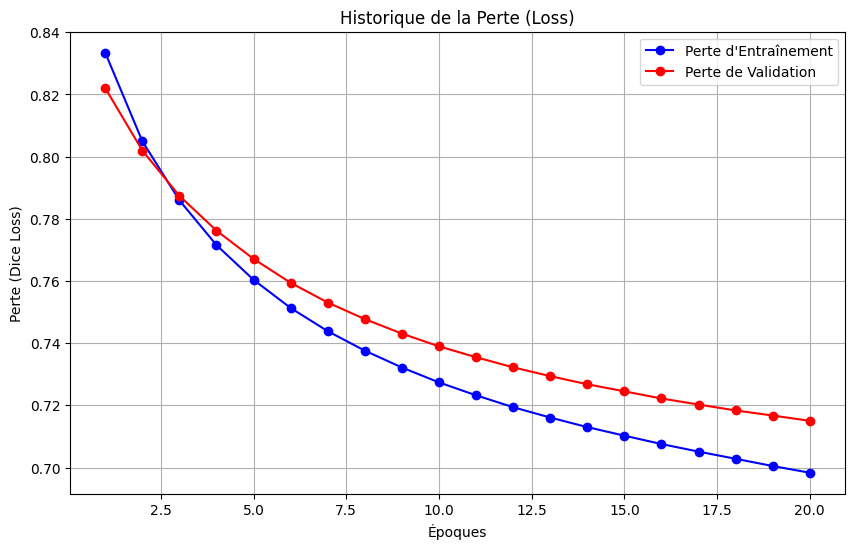

In [33]:
plot_loss_history(trainer.history)

In [48]:
import torch
import numpy as np

def generate_segmentations(model, data_loader, device, threshold=0.5):
    """
    Génère des masques de segmentation binaires à partir d'un DataLoader.

    Args:
        model (nn.Module): Le modèle UNet entraîné.
        data_loader (DataLoader): Le DataLoader (validation ou test).
        device (torch.device): Le dispositif (CPU ou CUDA).
        threshold (float): La valeur de seuil pour binariser la segmentation.

    Returns:
        list: Une liste de masques de segmentation binaires (NumPy arrays).
    """
    model.eval() # 1. Mettre le modèle en mode évaluation
    all_segmentations = []
    
    with torch.no_grad(): # Désactiver le calcul de gradient
        for data in data_loader:
            images = data['image'].to(device)
            
            # 2. Forward pass (obtention des logits)
            outputs = model(images)
            print("outputs",outputs)
            
            # 4. Seuilisation (Thresholding)
            # Binarise le masque : si probabilité > seuil, c'est un vaisseau (1)
            segmentations_tensor = (outputs > threshold).float()
            
            # 5. Conversion et stockage
            # Détache du GPU, convertit en NumPy, retire la dimension de canal (C=1)
            for seg in segmentations_tensor.cpu().numpy():
                all_segmentations.append(seg.squeeze())

    return all_segmentations

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image # Pour charger l'image originale si nécessaire

def display_segmentation_results(sample_dict, predicted_segmentation, index=None):
    """
    Affiche l'image originale, le masque de vérité terrain et la segmentation prédite.

    Args:
        original_image_path (str): Chemin vers le fichier de l'image originale.
                                   (Le canal vert traité n'est pas idéal pour la visualisation)
        ground_truth_mask (np.array): Le masque de vérité terrain (binaire, HxW).
        predicted_segmentation (np.array): Le masque de segmentation prédit (binaire, HxW).
        index (int, optional): L'index de l'échantillon pour le titre.
    """

    # Récupérer les Tenseurs
    image_tensor = sample_dict['image']
    gt_tensor = sample_dict['ground_truth']

    image_np = image_tensor.squeeze(0).cpu().numpy()
    gt_np = gt_tensor.squeeze(0).cpu().numpy()


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    title_suffix = f" (Index: {index})" if index is not None else ""

    axes[0].imshow(image_np, cmap='gray')
    axes[0].set_title(f"Image Traitée (Canal Vert + CLAHE){title_suffix}")
    axes[0].axis('off')

    # --- Afficher le Ground Truth (Masque de Vaisseaux) ---
    # Le masque est binaire (0 ou 1)
    axes[1].imshow(gt_np, cmap='gray')
    axes[1].set_title("Ground Truth (Vaisseaux)")
    axes[1].axis('off')

    # --- 3. Afficher la segmentation prédite ---
    print(predicted_segmentation)
    axes[2].imshow(predicted_segmentation, cmap='gray',vmin=0, vmax=1)
    axes[2].set_title("Segmentation Prédite")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [50]:
# Assurez-vous que val_loader est défini

THRESHOLD = 0.5 # Le seuil le plus courant est 0.5

predicted_segments_list = generate_segmentations(
    model=model,
    data_loader=val_loader,
    device=device,
    threshold=THRESHOLD
)

print(f"Nombre total de masques de segmentation récupérés : {len(predicted_segments_list)}")

outputs tensor([[[[0.3622, 0.2613, 0.2215,  ..., 0.2064, 0.2729, 0.3440],
          [0.3627, 0.2137, 0.1458,  ..., 0.1524, 0.2204, 0.3163],
          [0.3187, 0.1658, 0.1247,  ..., 0.1083, 0.1731, 0.3091],
          ...,
          [0.3453, 0.2092, 0.1473,  ..., 0.1239, 0.1901, 0.3006],
          [0.4291, 0.3065, 0.2336,  ..., 0.1904, 0.2359, 0.3142],
          [0.5061, 0.4442, 0.3753,  ..., 0.3498, 0.3857, 0.4353]]],


        [[[0.3656, 0.2650, 0.2256,  ..., 0.2082, 0.2722, 0.3455],
          [0.3679, 0.2175, 0.1490,  ..., 0.1533, 0.2213, 0.3148],
          [0.3268, 0.1713, 0.1290,  ..., 0.1094, 0.1740, 0.3078],
          ...,
          [0.3512, 0.2111, 0.1478,  ..., 0.1240, 0.1898, 0.2986],
          [0.4321, 0.3030, 0.2293,  ..., 0.1884, 0.2320, 0.3133],
          [0.5051, 0.4396, 0.3749,  ..., 0.3487, 0.3830, 0.4355]]],


        [[[0.3705, 0.2724, 0.2316,  ..., 0.2145, 0.2771, 0.3510],
          [0.3753, 0.2272, 0.1549,  ..., 0.1639, 0.2310, 0.3224],
          [0.3331, 0.1776, 0.1

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


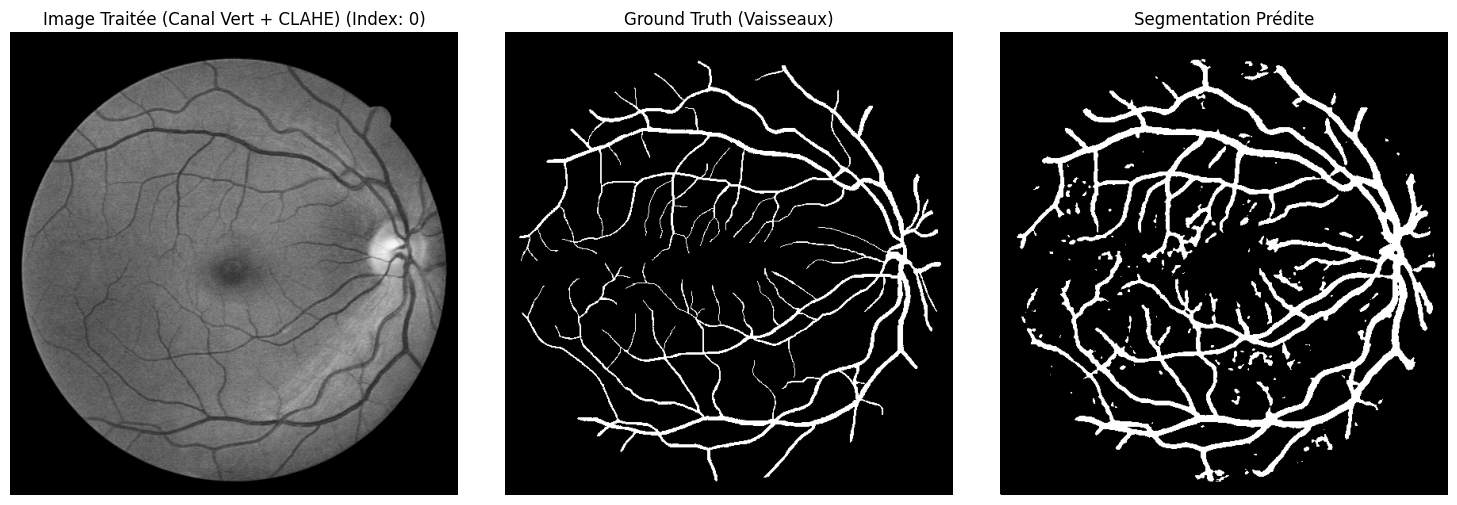

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


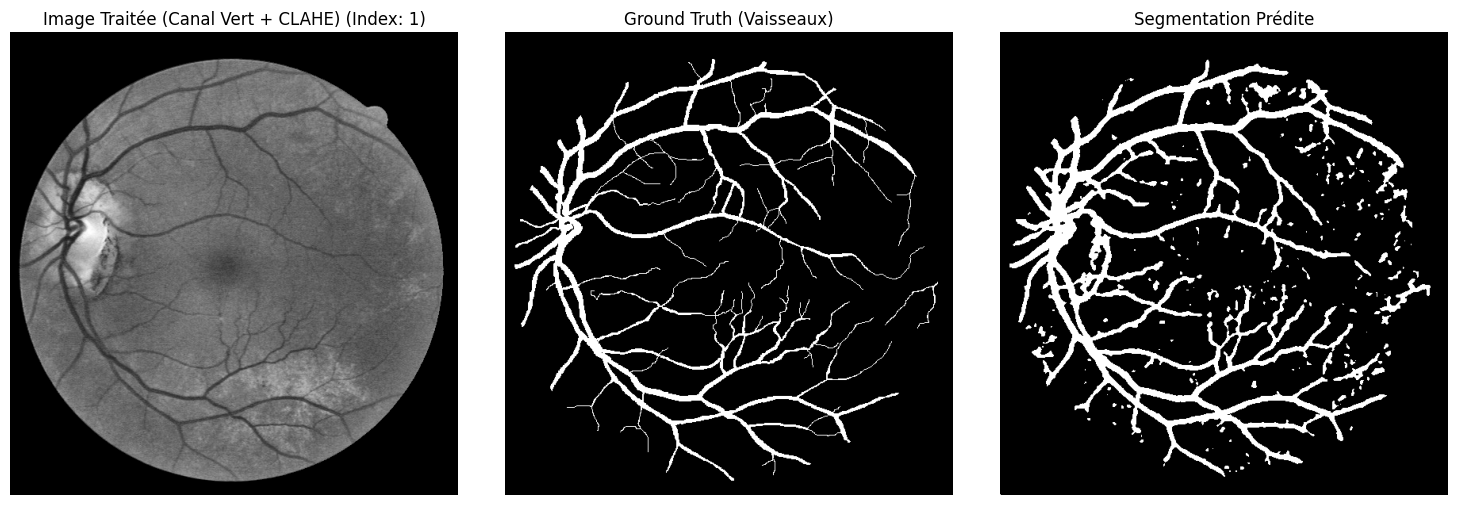

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


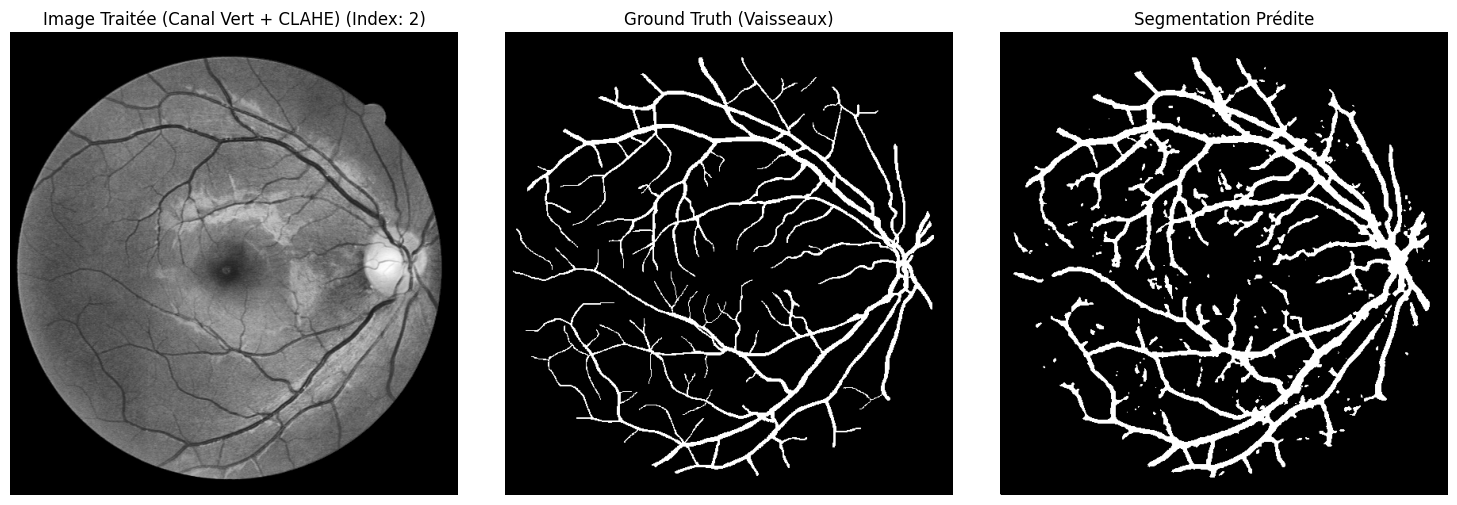

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


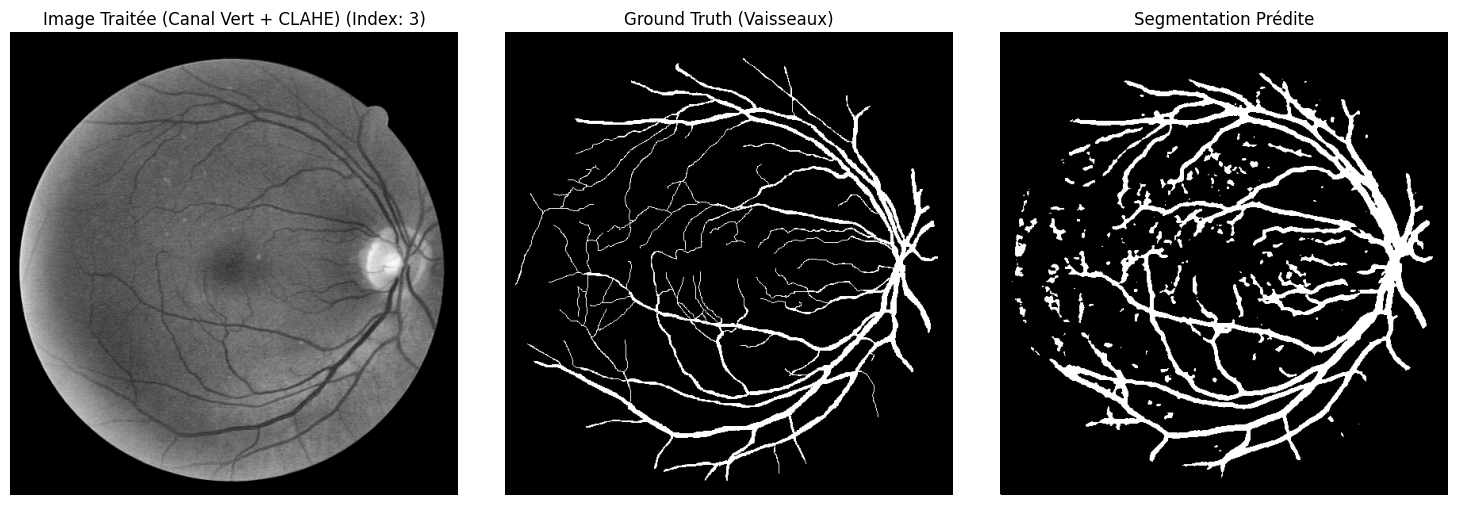

In [52]:
# Choisissez l'index de l'échantillon que vous voulez visualiser
for sample_index_to_view in range(len(predicted_segments_list)) : 

    # La prédiction est un NumPy array, directement issue de la liste générée.
    predicted_segmentation_np = predicted_segments_list[sample_index_to_view]

    sample_dict_for_display = val_subset[sample_index_to_view]

    display_segmentation_results(
        sample_dict=sample_dict_for_display,
        predicted_segmentation=predicted_segmentation_np,
        index=sample_index_to_view
    )